# Counterfactual Inference in Pyro

Below, we demonstrate a simple model of counterfactual inference in Pyro.  You will see a model relating treatment (cause) to blindness (outcome).  This toy example is technically a structural causal model (SCM).  SCMs enable twin-world counterfactual reasoning.  However, if we are working with a probabilistic programming language like Pyro, we don't have to stick to formal SCMs.  All we need is to have a set of variables from which all other sets of variables in the system are derived deterministically.  These "exogenous" variables are analogous to the initial conditions of a simulation.

The twin-world counterfactual reasoning algorithm is as follows

1. Condition on observed evidence and do inference on the exogenous variables.
2. Apply interventions to the model that reflect the counterfactual setting.
3. Forward sample from the intervention model using the posterior on the exogenous variables.

The intuition is that all the information in the observed world is shunted into the posterior of the exogenous variables, which are then passed over to the counterfactual world and forward probagated.

### Example: Blind treatment

This is an implementation of an example from Peters et al. 2017.

Consider a treatment study, where a company introduced a new medicine for eyes.

Suppose this is the true underlying model for the causal effect of Treatment $T$ ($T=1$ if the treatment was given) and the result $B$ ($B=1$ if the person goes blind).
$$
\begin{align}
N_T &\sim Ber(.5)\\ 
N_B &\sim Ber(.01) \\
 T &:= N_T \\
 B &:= T * N_B + (1-T)*(1-N_B) \\
\end{align}
$$

Suppose patient with poor eyesight comes to the hospital and goes blind (B=1) after the doctor gives treatment (T=1).  

We can ask "what would have happened had the doctor administered treatment T = 0?"

Here is the steps we follow to answer this counterfactual question.

1. Retrieve noise variables given observation.
   
   We observed $B=T=1$. Plugging that to the equations above
   
   $$\begin{align}
   1 &= N_T\\
   1 &= 1*N_B + (1-1)*(1-N_B)
   \end{align}$$
	
	So, $N_T=1$ and $N_B = 1$ 

2. Intervene on $T$. Put $T=0$, and solve for $B$

$$
\begin{align}
 T &= 0\\
 B &= 0 * 1 + (1-0)*(1-1) = 0 \\
\end{align}
$$

Thus, by this model, person would not have gone blind if the treatment was not given.

### Implementation of the twin-world counterfactual inference algorithm


In [1]:
import pyro
import pyro.distributions as dist
from pyro.infer import Importance, EmpiricalMarginal
from statistics import mean
import torch
import matplotlib.pyplot as plt

%matplotlib inline


exogenous_dists = {
    "N_t": dist.Bernoulli(torch.tensor(.5)),
    "N_b": dist.Bernoulli(torch.tensor(.01))
}

def model(exogenous_dists):
    N_t = pyro.sample("N_t", exogenous_dists["N_t"])
    N_b = pyro.sample("N_b", exogenous_dists["N_b"])
    t = pyro.sample("t", dist.Delta(N_t))
    b = pyro.sample("b", dist.Delta(t * N_b + (1. - t) * (1 - N_b)))
    return t, b


#### Condition on the observed world and do inference on the exogenous variables

In [2]:
conditioned = pyro.condition(
    model,
    {'t': torch.tensor(1.), 'b': torch.tensor(1.)}
)
# Sanity check: Exogenous vars become degenerate in posterior
posterior = Importance(
    conditioned,
    num_samples=100).run(exogenous_dists)
N_t_marginal = EmpiricalMarginal(posterior, "N_t")

N_T_samples = [N_t_marginal().item() for _ in range(1000)]
print(mean(N_T_samples))

N_b_marginal = EmpiricalMarginal(posterior, "N_b")

N_b_samples = [N_b_marginal().item() for _ in range(1000)]
print(mean(N_b_samples))

1.0
1.0


#### Apply counterfactual intervention to the model

In [3]:
cf_model = pyro.do(model, {'t': torch.tensor(0.)})

#### Forward propagate posterior of exogenous variables

(array([  0.,   0.,   0.,   0.,   0., 100.,   0.,   0.,   0.,   0.]),
 array([-0.5, -0.4, -0.3, -0.2, -0.1,  0. ,  0.1,  0.2,  0.3,  0.4,  0.5],
       dtype=float32),
 <a list of 10 Patch objects>)

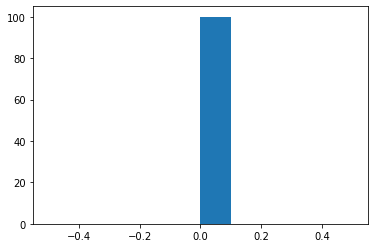

In [4]:
updated_exogenous_dists = {
    "N_t": dist.Bernoulli(torch.tensor(mean(N_T_samples))),
    "N_b": dist.Bernoulli(torch.tensor(mean(N_b_samples)))
}
samples = [cf_model(updated_exogenous_dists) for _ in range(100)]
b_samples = [b for _, b in samples]
plt.hist(b_samples)


Note that the inference here is brittle, and you may have to run this script a few times to get the appropriate output.  This is typically the case with using probabilistic programming to implement twin-world counterfactuals.

Newer languages specifically designed for this problem, like [Omega

## Reference
Dominik Janzing, and Bernhard Schölkopf. Elements of causal inference: foundations and learning algorithms. MIT press, 2017